In [1]:
import re

file_path = "amazon-meta.txt"

#store parsed data
items = []
similar_items = []
categories = []
reviews = []

#parse
def parse_categories(line):
    categories = []
    for part in line.split("|"):
        if part:  # Avoid empty strings
            category_name = part.split("[")[0].strip()
            categories.append(category_name)
    return categories
def parse_review_line(line):
    match = re.match(r"(\d{4}-\d{1,2}-\d{1,2})\s+cutomer:\s+(\S+)\s+rating:\s+(\d+)\s+votes:\s+(\d+)\s+helpful:\s+(\d+)", line)
    if match:
        return {
            "Date": match.group(1),
            "CustomerId": match.group(2),
            "Rating": int(match.group(3)),
            "Votes": int(match.group(4)),
            "Helpful": int(match.group(5)),
        }
    return None

# reading and parsing file
with open(file_path, "r") as file:
    current_item = None
    for line in file:
        line = line.strip()

        if line.startswith("Id:"):
            if current_item: 
                items.append(current_item)
            current_item = {"Id": int(line.split(":")[1].strip()), "Similar": [], "Categories": [], "Reviews": []}

        elif line.startswith("ASIN:"):
            current_item["ASIN"] = line.split(":")[1].strip()

        elif line.startswith("title:"):
            current_item["Title"] = line.split("title:")[1].strip()

        elif line.startswith("group:"):
            current_item["Group"] = line.split("group:")[1].strip()

        elif line.startswith("salesrank:"):
            current_item["SalesRank"] = int(line.split("salesrank:")[1].strip())

        elif line.startswith("similar:"):
            similar_asins = line.split()[2:] 
            current_item["Similar"] = similar_asins

        elif line.startswith("categories:"):
            pass  #placeholder

        elif re.match(r"\|", line):  #category line starts with "|"
            current_item["Categories"].extend(parse_categories(line))

        elif line.startswith("reviews:"):
            pass  #skip for now

        elif re.match(r"\d{4}-\d{1,2}-\d{1,2}", line):  
            review = parse_review_line(line)
            if review:
                current_item["Reviews"].append(review)

        elif line.startswith("discontinued product"):
            current_item = None

    if current_item:
        items.append(current_item)

#organize data
for item in items:
    item_id = item["Id"]
    for sim in item["Similar"]:
        similar_items.append((item_id, sim))
    for category in item["Categories"]:
        categories.append((item_id, category))
    for review in item["Reviews"]:
        reviews.append((item_id, review["CustomerId"], review["Rating"], review["Votes"], review["Helpful"]))

Parses data and structures in order to insert into database and transform

In [2]:
import sqlite3

#connect to database
conn = sqlite3.connect("amazon_items.db")
cursor = conn.cursor()

#create tables
cursor.execute("""
CREATE TABLE Items (
    ItemId INTEGER PRIMARY KEY,
    ASIN TEXT UNIQUE,
    Title TEXT,
    GroupName TEXT,
    SalesRank INTEGER
)""")

cursor.execute("""
CREATE TABLE SimilarItems (
    ItemId INTEGER,
    SimilarItemId TEXT,
    FOREIGN KEY (ItemId) REFERENCES Items(ItemId)
)""")

cursor.execute("""
CREATE TABLE Categories (
    CategoryId INTEGER PRIMARY KEY AUTOINCREMENT,
    ItemId INTEGER,
    CategoryName TEXT,
    FOREIGN KEY (ItemId) REFERENCES Items(ItemId)
)""")

cursor.execute("""
CREATE TABLE Reviews (
    ReviewId INTEGER PRIMARY KEY AUTOINCREMENT,
    ItemId INTEGER,
    CustomerId TEXT,
    Rating INTEGER,
    Votes INTEGER,
    Helpful INTEGER,
    FOREIGN KEY (ItemId) REFERENCES Items(ItemId)
)""")

#insert data!
cursor.executemany("INSERT INTO Items (ItemId, ASIN, Title, GroupName, SalesRank) VALUES (?, ?, ?, ?, ?)",
                   [(item["Id"], item["ASIN"], item.get("Title"), item.get("Group"), item.get("SalesRank")) for item in items])

cursor.executemany("INSERT INTO SimilarItems (ItemId, SimilarItemId) VALUES (?, ?)", similar_items)
cursor.executemany("INSERT INTO Categories (ItemId, CategoryName) VALUES (?, ?)", categories)
cursor.executemany("INSERT INTO Reviews (ItemId, CustomerId, Rating, Votes, Helpful) VALUES (?, ?, ?, ?, ?)", reviews)

conn.commit()
conn.close()


OperationalError: table Items already exists

Stores data in SQL database using sqlite, populated with the previously parsed data.

In [3]:
conn = sqlite3.connect("amazon_items.db")
cursor = conn.cursor()

def print_table(table_name):
    print(f"--- {table_name} (First 5 Rows) ---")
    cursor.execute(f"SELECT * FROM {table_name} LIMIT 15")  
    rows = cursor.fetchall()
    if rows:
        for row in rows:
            print(row)
    else:
        print("No data found.")
    print()

#print the first 15 rows of these tables
tables = ["Items", "SimilarItems", "Categories", "Reviews"]
for table in tables:
    print_table(table)

conn.close()

--- Items (First 5 Rows) ---
(1, '0827229534', 'Patterns of Preaching: A Sermon Sampler', 'Book', 396585)
(2, '0738700797', 'Candlemas: Feast of Flames', 'Book', 168596)
(3, '0486287785', 'World War II Allied Fighter Planes Trading Cards', 'Book', 1270652)
(4, '0842328327', 'Life Application Bible Commentary: 1 and 2 Timothy and Titus', 'Book', 631289)
(5, '1577943082', 'Prayers That Avail Much for Business: Executive', 'Book', 455160)
(6, '0486220125', 'How the Other Half Lives: Studies Among the Tenements of New York', 'Book', 188784)
(7, 'B00000AU3R', 'Batik', 'Music', 5392)
(8, '0231118597', 'Losing Matt Shepard', 'Book', 277409)
(9, '1859677800', 'Making Bread: The Taste of Traditional Home-Baking', 'Book', 949166)
(10, '0375709363', 'The Edward Said Reader', 'Book', 220379)
(11, '0871318237', 'Resetting the Clock : Five Anti-Aging Hormones That Improve and Extend Life', 'Book', 412962)
(12, '1590770218', 'Fantastic Food with Splenda : 160 Great Recipes for Meals Low in Sugar, Car

Prints the first 15 lines of "Items", "SimilarItems", "Categories", "Reviews" tables.

## RECOMMENDATION

In [5]:
#for item a given customer rated 5 stars
#find other customers who rated it 5 stars
  #find any products those customers also rated 5 stars
#recommend those products

conn = sqlite3.connect("amazon_items.db")
cursor = conn.cursor()

recommendationQuery = """
SELECT DISTINCT r3.ItemId, i.Title
FROM Reviews r1
JOIN Reviews r2 ON r1.ItemId = r2.ItemId
JOIN Reviews r3 ON r2.CustomerId = r3.CustomerId
JOIN Items i ON r3.ItemId = i.ItemId
WHERE r1.CustomerId = ?
  AND r1.Rating = 5
  AND r2.Rating = 5
  AND r3.Rating = 5
  AND r2.CustomerId != ?
  AND r3.ItemId NOT IN (
    SELECT ItemId
    FROM Reviews
    WHERE CustomerId = ?
)
GROUP BY r3.ItemId
HAVING COUNT(r2.CustomerId) > 2
ORDER BY COUNT(r2.CustomerId) DESC
LIMIT 20; 
"""

customer_id = 'A3PE8INQFIEP9G'

#execute
cursor.execute(recommendationQuery, (customer_id, customer_id, customer_id))

recommendations = cursor.fetchall()
print("Recommended products:")
for item_id, title in recommendations:
    print(f"Item ID: {item_id}, Title: {title}")

conn.close()



Recommended products:
Item ID: 91158, Title: Harry Potter and the Sorcerer's Stone (Book 1)
Item ID: 211463, Title: Harry Potter and the Sorcerer's Stone (Book 1 Audio CD)
Item ID: 23792, Title: Harry Potter and the Sorcerer's Stone
Item ID: 428073, Title: Harry Potter and the Sorcerer's Stone (Book 1, Large Print)
Item ID: 546259, Title: Harry Potter and the Sorcerer's Stone (Book 1, Audio)
Item ID: 526761, Title: Harry Potter and the Sorcerer's Stone (Book 1)
Item ID: 250879, Title: Harry Potter and the Sorcerer's Stone (Book 1 Audio CD)
Item ID: 186948, Title: Millennium
Item ID: 449174, Title: Harry Potter and the Chamber of Secrets (Book 2)
Item ID: 45703, Title: Harry Potter and the Chamber of Secrets, Braille Edition
Item ID: 415840, Title: Harry Potter and the Chamber of Secrets (Book 2)
Item ID: 189465, Title: Harry Potter and the Chamber of Secrets (Book 2 Audio CD)
Item ID: 544883, Title: Harry Potter and the Chamber of Secrets (Book 2, Audio)
Item ID: 534181, Title: Harry P

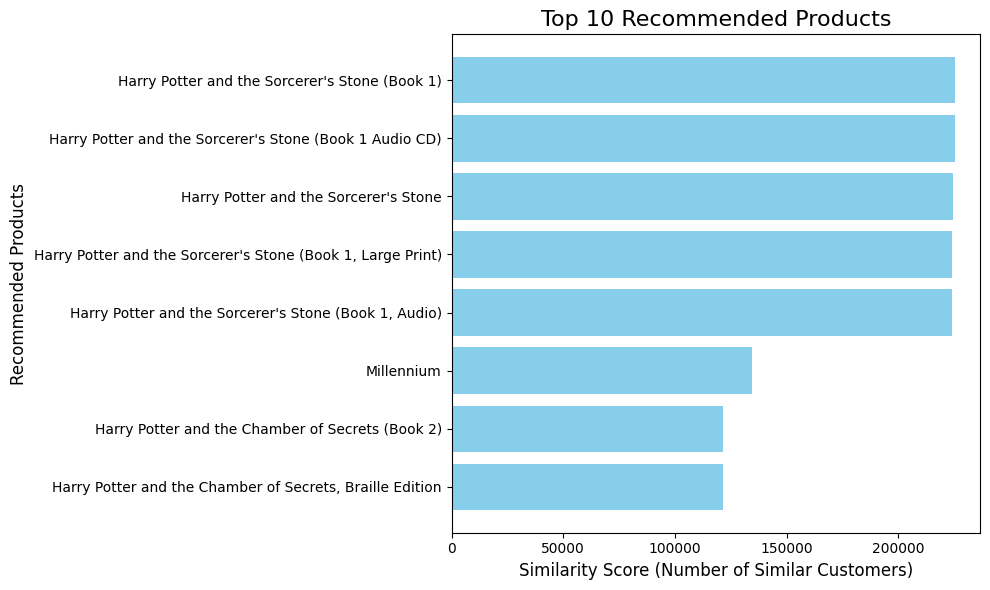

In [6]:
import sqlite3
import matplotlib.pyplot as plt

# Connect to the database
conn = sqlite3.connect("amazon_items.db")
cursor = conn.cursor()

# SQL query to fetch recommendations
recommendationQuery = """
SELECT DISTINCT r3.ItemId, i.Title, COUNT(r2.CustomerId) as SimilarityScore
FROM Reviews r1
JOIN Reviews r2 ON r1.ItemId = r2.ItemId
JOIN Reviews r3 ON r2.CustomerId = r3.CustomerId
JOIN Items i ON r3.ItemId = i.ItemId
WHERE r1.CustomerId = ?
  AND r1.Rating = 5
  AND r2.Rating = 5
  AND r3.Rating = 5
  AND r2.CustomerId != ?
  AND r3.ItemId NOT IN (
    SELECT ItemId
    FROM Reviews
    WHERE CustomerId = ?
)
GROUP BY r3.ItemId
HAVING COUNT(r2.CustomerId) > 2
ORDER BY SimilarityScore DESC
LIMIT 10; -- Fetch top 10 recommendations
"""

#execute
customer_id = 'A3PE8INQFIEP9G'
cursor.execute(recommendationQuery, (customer_id, customer_id, customer_id))
recommendations = cursor.fetchall()

conn.close()

titles = [row[1] for row in recommendations]
scores = [row[2] for row in recommendations]

#plot
plt.figure(figsize=(10, 6))
plt.barh(titles, scores, color="skyblue")
plt.xlabel("Similarity Score (Number of Similar Customers)", fontsize=12)
plt.ylabel("Recommended Products", fontsize=12)
plt.title("Top 10 Recommended Products", fontsize=16)
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


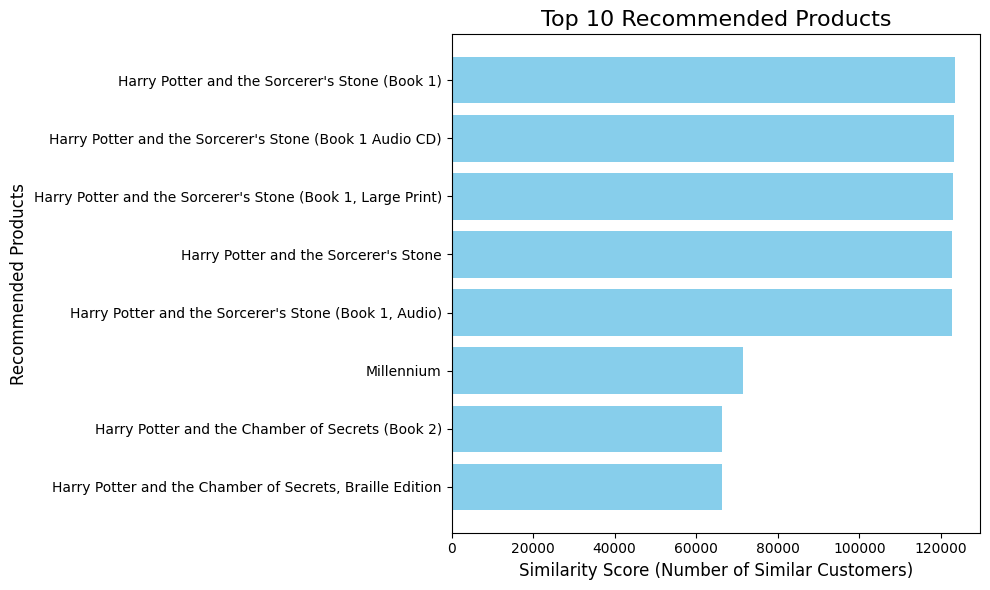

In [4]:
import sqlite3
import matplotlib.pyplot as plt

# Connect to the database
conn = sqlite3.connect("amazon_items.db")
cursor = conn.cursor()

# SQL query to fetch recommendations
recommendationQuery = """
SELECT DISTINCT r3.ItemId, i.Title, COUNT(r2.CustomerId) as SimilarityScore
FROM Reviews r1
JOIN Reviews r2 ON r1.ItemId = r2.ItemId
JOIN Reviews r3 ON r2.CustomerId = r3.CustomerId
JOIN Items i ON r3.ItemId = i.ItemId
WHERE r1.CustomerId = ?
  AND r1.Rating = 5
  AND r2.Rating = 5
  AND r3.Rating = 5
  AND r2.CustomerId != ?
  AND r3.ItemId NOT IN (
    SELECT ItemId
    FROM Reviews
    WHERE CustomerId = ?
)
GROUP BY r3.ItemId
HAVING COUNT(r2.CustomerId) > 2
ORDER BY SimilarityScore DESC
LIMIT 10; 
"""

#CUSTOMER WHO BOUGHT "Scooby Doo Zombie Island"
customer_id = 'A2H0T0PY5IMEFX'
cursor.execute(recommendationQuery, (customer_id, customer_id, customer_id))
recommendations = cursor.fetchall()

conn.close()

titles = [row[1] for row in recommendations]
scores = [row[2] for row in recommendations]

#plot
plt.figure(figsize=(10, 6))
plt.barh(titles, scores, color="skyblue")
plt.xlabel("Similarity Score (Number of Similar Customers)", fontsize=12)
plt.ylabel("Recommended Products", fontsize=12)
plt.title("Top 10 Recommended Products", fontsize=16)
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


In [18]:
import sqlite3
import matplotlib.pyplot as plt

# Connect to the database
conn = sqlite3.connect("amazon_items.db")
cursor = conn.cursor()

# SQL query to fetch recommendations
recommendationQuery = """
SELECT DISTINCT r3.ItemId, i.Title, 
       COUNT(r2.CustomerId) as SimilarityScore
FROM Reviews r1
JOIN Reviews r2 ON r1.ItemId = r2.ItemId
JOIN Reviews r3 ON r2.CustomerId = r3.CustomerId
JOIN Items i ON r3.ItemId = i.ItemId
WHERE r1.CustomerId = ?
  AND r1.Rating = 5
  AND r2.Rating = 5
  AND r3.Rating = 5
  AND r2.CustomerId != ?
  AND r3.ItemId NOT IN (
    SELECT ItemId
    FROM Reviews
    WHERE CustomerId = ?
  )
  AND i.GroupName = (
    SELECT GroupName
    FROM Items
    WHERE ItemId IN (
      SELECT ItemId
      FROM Reviews
      WHERE CustomerId = ?
      LIMIT 1
    )
  )
GROUP BY r3.ItemId
HAVING COUNT(r2.CustomerId) > 2
ORDER BY SimilarityScore DESC, RANDOM()
LIMIT 10;
"""

#CUSTOMER WHO BOUGHT "NYSYNC"
customer_id = 'A2G7F89REDD1MX'
cursor.execute(recommendationQuery, (customer_id, customer_id, customer_id, customer_id))
recommendations = cursor.fetchall()

conn.close()

titles = [row[1] for row in recommendations]
scores = [row[2] for row in recommendations]

#plot
plt.figure(figsize=(10, 6))
plt.barh(titles, scores, color="skyblue")
plt.xlabel("Similarity Score (Number of Similar Customers)", fontsize=12)
plt.ylabel("Recommended Products", fontsize=12)
plt.title("Top 10 Recommended Products", fontsize=16)
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


In [10]:
conn = sqlite3.connect("amazon_items.db")
cursor = conn.cursor()

conn.execute("VACUUM;")
conn.commit()
